# 15.774/15.780 Fall 2023
## The Analytics of Operations Management
### Problem Set 4 - Supply Chain Optimization 
#### Due Date:  11/17
---
Name of Student: Joy Bhattacharya

MIT ID Number: 922631264

---

### Instructions:

1) Submit solutions that are your own, in your own words. You are allowed to discuss with other students in general terms, but make sure you are not copying verbatim from another student. Therefore do not read other students' solutions. If you use material from outside this class, reference it in your solution. 

2) Please download the python file attached in the assignment and complete your answers there in the same file. Read the questions carefully, and make sure you answer every part that the question asks.

3) Include relevant code in the PDF submission even if the question doesn't explicitly ask for it. Upload your solutions as a PDF file. Include your name and MIT ID on the first page.

4) To convert to pdf, you can use the "print to pdf" option in jupyter (or equivalent options in other IDE). There are other options to directly download in to pdf format which might include additional installation of packages. 

5) Show your work and explain your conclusions clearly and precisely. Plots should have clear titles and axis labels so that it is clear what your analysis is showing.

--------------------------------------------------------------------------------------------------------------------------------

## Load Packages

In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from HW4_data import *
%whos

C:\Users\joyse\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Variable   Type       Data/Info
-------------------------------
CE         ndarray    7: 7 elems, type `float64`, 56 bytes
CEU        ndarray    9x7: 63 elems, type `float64`, 504 bytes
GRB        type       <class 'gurobipy.GRB'>
OEMD       ndarray    9x7: 63 elems, type `int32`, 252 bytes
PSCU       ndarray    9x7: 63 elems, type `float64`, 504 bytes
SCMT       ndarray    9x7: 63 elems, type `float64`, 504 bytes
UPC        ndarray    9: 9 elems, type `float64`, 72 bytes
gp         module     <module 'gurobipy' from '<...>\\gurobipy\\__init__.py'>
np         module     <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
pd         module     <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
plt        module     <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>


---
## $\textbf{Problem 1. Supply Chain Optimization}$ (75 pts)
In all the problem set, fill in the missing variables and constraints (i.e. whenever is "Variable = " or "Constraint = " you should fill in with your answer. 
1. Based on the information in the case, assign appropriate values to the constants in the following cell. (5 pts)

In [39]:
# Total budget allocated for supply chain
TotalBudget = 3000000000


# Total TV sets order by the customers from all ODMs by TV size
TotalUnits42 = 920000
TotalUnits32 =  530000

# Number of ODMs (treat ODMs making two different sizes as if they were separate ODMs, i.e., count them twice)
NumODM = 9

# Number of transportation options
NumTran = 7

# Minimum order size of 42" or 32" TV sets from any selected ODM
MinProd = 200000

# Maximum order size of 42" or 32" TV sets from any selected ODM
MaxProd = 600000

# Minimum number of 42" / 32" TV sets shipped by Regular Air or Air Express
MinAir42 = 46000 
MinAir32 = 53000

# Minimum number of 42" / 32" TV sets shipped by Road, Road LTL, or Road Network
MinRoad42 = 92000
MinRoad32 = 79500

# Minimum number of 42" / 32" TV sets shipped by shipped by Rail
MinRail42 = 138000
MinRail32 = 79500

In [3]:
print(gp.gurobi.version())

(10, 0, 2)


In [2]:
# Set up Gurobi environment
env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)
env.start()

# Initialize the model
m = gp.Model(env=env)

---
2. Add decision variables to the model. (5 pts)

In [41]:
### Decision Variables ###

# A vector of binary decision variables that denote which ODMs are selected
X = m.addVars((i for i in range(0,9)), vtype=GRB.BINARY, name='X')
              

# Supply Chain Matrix
# Indicates how many TV sets will be produced by the selected ODMs and how they will be shipped to the distribution center
i=9
j=7
SCM = m.addMVar((i,j))

---
3. Add minimum and maximum order size constraints for the ODMs. (5 pts)

In [42]:
### Constraints ###
# Total production for each ODM must be greater than the minimum order size if the ODM is selected
#Const1a = m.addConstrs((sum(SCM[i,j] for i in range(0,9) for j in range(0,7))>=X[i]*MinProd), name='Const1a')
Const1a= m.addConstrs((gp.quicksum(SCM[i, j] for j in range(0, 7)) >= X[i] * MinProd for i in range(0, 9)), name='Const1a')

# Total production for each ODM must be less than the maximum order size if the ODM is selected
Const1b = m.addConstrs((gp.quicksum(SCM[i, j] for j in range(0, 7)) <= X[i] * MaxProd for i in range(0, 9)), name='Const1b')

---
4. Add constraints for the minimum shipping requirements by transportation mode. (5 pts)

In [43]:
# Total number of TVs for each shipping mode must be greater than the Minimum Shipping Requirement
Const2a1 =  m.addConstr((gp.quicksum(SCM[i, j] for i in range(7) for j in range(2)) >= MinAir42), name='Const2a1')

Const2b1 = m.addConstr((gp.quicksum(SCM[i, j] for i in range(7) for j in range(2,5)) >= MinRoad42), name='Const2b1') 

Const2c1 =  m.addConstr((gp.quicksum(SCM[i, 5] for i in range(7)) >= MinRail42), name='Const2c1') 


# 42" Rail
Const2a2 =   m.addConstr((gp.quicksum(SCM[i, j] for i in range(7,9) for j in range(2)) >= MinAir32), name='Const2a2')


# 32" Regular Air or Air Express
Const2b2 =   m.addConstr((gp.quicksum(SCM[i, j] for i in range(7,9) for j in range(2,5)) >= MinRoad32), name='Const2b2')   

# 32" Road, Road LTL, or Road Network
Const2c2 =   m.addConstr((gp.quicksum(SCM[i, 5] for i in range(7,9)) >= MinRail32), name='Const2c2') 

# 32" Rail

---
5. Add any shipping method constraints for specific ODMs. (5 pts)

In [44]:
# ODM5 can't ship by Regular Air, Air Express, Rail, or Water (Hint: SCM [4, 1] corresponding to ODM5 shipping via Air Express)
Const3a = m.addConstr((SCM[4,0]==0), name='Const3a')                 # Regular Air
Const3b = m.addConstr((SCM[4,1]==0), name='Const3b')                  # Air Express
Const3c = m.addConstr((SCM[4,5]==0), name='Const3c')                  # Rail
Const3d = m.addConstr((SCM[4,6]==0), name='Const3d')                  # Water

# ODM6 can't ship by Road, Road LTL, Road Network, and Rail
Const4a = m.addConstr((SCM[5,2]==0), name='Const4a')                 # Road
Const4b =  m.addConstr((SCM[5,3]==0), name='Const4b')                 # Road LTL
Const4c =  m.addConstr((SCM[5,4]==0), name='Const4c')                 # Road Network
Const4d =   m.addConstr((SCM[5,5]==0), name='Const4d')                #Rail

---
6. Add your budget constraint. (5 pts)

In [45]:
# Total cost must be less than total budget, be sure to name this constraint 'Const5'!
Const5 = m.addConstr((gp.quicksum(SCM[i, j]*PSCU[i,j] for i in range(9) for j in range(7))<=TotalBudget), name='Const5')



---
7. Add quantity constraints for each TV size (920,000 LCD 42” and 530,000 LCD 32”). (5 pts)

In [46]:
# Total units for each model must be equal to the desired quantities
Const6a =  m.addConstr((gp.quicksum(SCM[i, j] for i in range(7) for j in range(7))==TotalUnits42), name='Const6a')  


# 42" Total Units
Const6b =  m.addConstr((gp.quicksum(SCM[i, j] for i in range(7,9) for j in range(7))==TotalUnits32), name='Const6b')    

# 32" Total Units

---
8. Add an objective function minimizing CO2 emissions. (5 pts)

In [47]:
# Objective function: minimize CO2 emissions
m.setObjective(
    gp.quicksum(SCM[i, j]*CEU[i,j] for i in range(9) for j in range(7)), GRB.MINIMIZE)



---
9. Solve the model. What is the optimal objective function value (total CO2 emission)? (5 pts)

In [48]:
# Update and write the model
m.update() # Update model parameters
m.write("HW4.lp") # Write model to file

In [49]:
# Solve
m.optimize()

In [50]:
m.objVal
    
    


7401309.8902599905

---
10. In the optimal solution, which ODMs are selected and how much is ordered from each ODM? (5 pts)

In [52]:
# Print the optimal decsion variable solutions
transport_names = ['Air', 'Express', 'Road', 'Road LTL', 'Road-Network', 'Rail', 'Water']
ODM_names = ['LCD 42" ODM1', 'LCD 42" ODM2', 'LCD 42" ODM3', 'LCD 42" ODM4', 'LCD 42" ODM5', 
             'LCD 42" ODM6', 'LCD 42" ODM7', 'LCD 32" ODM1', 'LCD 32" ODM2']

pd.DataFrame(SCM.getAttr('x'), index= ODM_names , columns=transport_names ) # You must fill in the values for index and columns

,Air,Express,Road,Road LTL,Road-Network,Rail,Water
"LCD 42"" ODM1",0.0,0.0,0.0,0.0,90450.0,0.0,229550.0
"LCD 42"" ODM2",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM3",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM4",46000.0,0.0,0.0,0.0,1550.0,138000.0,414450.0
"LCD 42"" ODM5",-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
"LCD 42"" ODM6",0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
"LCD 42"" ODM7",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 32"" ODM1",53000.0,0.0,0.0,0.0,79500.0,79500.0,318000.0
"LCD 32"" ODM2",0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
11. In the optimal solution, check whether the budget constraint is binding (i.e., is the CNY 3 billion
budget fully used)? (5 pts)

In [54]:
# Calculate used budget
used_budget=0
for i in range(9):
    for j in range(7):
        used_budget += SCM.x[i,j]*PSCU[i,j]
used_budget

3000000000.0

**Comment**: The constraint is binding since we used the entire budget. 

---
12. Now imagine your budget is increased by 10% to CNY 3.3 billion. How much and by what percentage
is the CO2 emission reduced? How does your optimal sourcing decisions change? Do you see a shift in
the modes of transportation compared to the case with CNY 3 billion budget? Is this surprising? (10
pts)

In [55]:
newTotalBudget = 3300000000
# Hint: You can change the value of the total budget with this command, by changing the right
# hand side of Constraint 5, be sure constraint 5 is named 'Const5'
m.getConstrByName('Const5').setAttr('RHS', newTotalBudget)

# Re-solve
m.update()
m.optimize()

# Print optimal objective function value
print("\nObjective value: ", m.getAttr("ObjVal"))

pd.DataFrame(SCM.getAttr('x'), index=ODM_names , columns=transport_names )  # You must fill in the values for index and columns


Objective value:  3479982.2601499995


,Air,Express,Road,Road LTL,Road-Network,Rail,Water
"LCD 42"" ODM1",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM2",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM3",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM4",0.0,0.0,0.0,0.0,0.0,0.0,320000.0
"LCD 42"" ODM5",-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
"LCD 42"" ODM6",0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
"LCD 42"" ODM7",46000.0,0.0,0.0,0.0,92000.0,138000.0,324000.0
"LCD 32"" ODM1",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 32"" ODM2",53000.0,0.0,0.0,0.0,79500.0,79500.0,318000.0


In [56]:
change_in_carbon=((7401309.8902599905-3479982.2601499995)/7401309.8902599905)*100
change_in_carbon

52.98153554238281

**Comment**: The C02 emissions reduced from 7.4 million to 3.4 million. This is a 52% decrease in carbon emissions. Before, we were sourcing only from ODM1 and ODM 4, using a combination of air, road network, rail, and water but primarily the latter three. Now that we've increased our budget, we are sourcing from ODM2, ODM4, and ODM7. This makes sense because we've switched to ODMs that are more carbon friendly even though they have higher production/shipping costs than before because we can now afford them with our increased budget. For instance, ODM2 has much higher shipping costs than ODM1 but it produces a lot less carbon emissions. For the transporation, we are still using air, road-network, rail, and water, and shipping about the same total quantities in those tranportation categories as before. 







---
13. Imagine your budget increases by the following percentages: 0%, 2%, 4%, 6%, 10%, 12%, and 14%.
For each of these budgets, find the CO2 emission under the optimal solution (re-run your optimization
model for each of these budgets). Plot these results where the x-axis in the %Budget Increase and the
y-axis is the CO2 Emission. Show the chart. What do you observe? (10 pts)

In [58]:
# sensitivity table
budget_sensitivity = [0, 0.02, 0.04, 0.06, 0.08, 0.10, .12, .14]
emissions = []
for sensitivity in budget_sensitivity:
    newTotalBudget = (1+sensitivity)*3000000000
    # Hint: You can change the value of the total budget with this command
    m.getConstrByName('Const5').setAttr('RHS', newTotalBudget)

    # Re-solve
    m.update()
    m.optimize()

    # Print optimal objective function value
    emissions.append(m.getAttr("ObjVal"))
    
print(emissions)

[7401309.8902599905, 5513060.483081695, 4542391.076797709, 3572591.489201123, 3502042.7601499995, 3479982.2601499995, 3416981.6962133604, 3373499.9820685117]


<function matplotlib.pyplot.show(*args, **kw)>

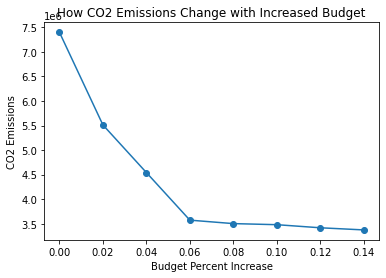

In [59]:
# Plot your results

plt.plot(budget_sensitivity, emissions, marker='o')
plt.xlabel('Budget Percent Increase')
plt.ylabel('CO2 Emissions')
plt.title('How CO2 Emissions Change with Increased Budget')
plt.show





**Comment**: As our budget increases, our CO2 emissions decrease. This makes sense because with a greater budget, we can afford to produce from ODMs that are more expensive but produce less emissions. We see the biggest drop in emissions as we go from our original budget to about a 6% increase in the budget. After increasing our budget past 6%, the CO2 emissions level off and the decrease in CO2 is marginal. This shows that increasing the budget is only helpful to decreasing CO2 emissions up until a certain point. After that point, there are not many ways to change our ODMs/transportation methods to drastically decrease CO2 emissions anymore. 